In [1]:
import re

def removePunctuation(text):
    text=re.sub("[^0-9a-zA-Z ]", " ", text)
    return text

In [3]:
textRDD = sc.newAPIHadoopFile('../Data/Moby-Dick-Edited.txt',
                              'org.apache.hadoop.mapreduce.lib.input.TextInputFormat',
                              'org.apache.hadoop.io.LongWritable',
                              'org.apache.hadoop.io.Text',
                               conf={'textinputformat.record.delimiter': "\r\n\r\n"}) \
            .map(lambda p: p[1])

sentences=textRDD.flatMap(lambda x: x.split(". "))

In [4]:
sentences = sentences.map(removePunctuation).map(lambda x: x.lower())
sentences.take(3)

[u'moby dick  or the whale', u'by herman melville', u'']

In [7]:
k=2  # k is part of the environment variables of the function. Spark sends the value of the referenced variables 
     # to the slave nodes.
sc.broadcast(k)
def ngram(sentence):
    """
    :return: (ngram, 1)
    """
    for i in range(len(sentence)-k):
        yield (tuple(sentence[i:i+k]), 1)
        
list(ngram(sentences.map(lambda x:x.split()).first()))

[((u'moby', u'dick'), 1), ((u'dick', u'or'), 1), ((u'or', u'the'), 1)]

In [9]:
from operator import add 
freq_ngrams = [None]*6
for k in range(1,6):
    ngrams = sentences.map(lambda x: x.split()).flatMap(ngram)
    freq_ngrams[k] = ngrams.reduceByKey(add).map(lambda (k, v): (v, k)).sortByKey(False)
    m = 5
    top = freq_ngrams[k].take(m)
    print '\n============ %d most frequent %d-grams'% (m, k)
    print '\nindex\tcount\tngram'
    for i in range(m):
        cnt, gram = top[i]
        print '%d.\t%d: \t"%s"'%(i+1, cnt, ' '.join(gram))


============ 5 most frequent 1-grams

index	count	ngram
1.	14440: 	"the"
2.	6608: 	"of"
3.	6432: 	"and"
4.	4741: 	"a"
5.	4609: 	"to"

============ 5 most frequent 2-grams

index	count	ngram
1.	1880: 	"of the"
2.	1179: 	"in the"
3.	730: 	"to the"
4.	441: 	"from the"
5.	376: 	"the whale"

============ 5 most frequent 3-grams

index	count	ngram
1.	109: 	"the sperm whale"
2.	93: 	"of the whale"
3.	79: 	"the white whale"
4.	64: 	"one of the"
5.	58: 	"out of the"

============ 5 most frequent 4-grams

index	count	ngram
1.	39: 	"of the sperm whale"
2.	26: 	"the sperm whale s"
3.	20: 	"at the same time"
4.	18: 	"of the whale s"
5.	17: 	"the bottom of the"

============ 5 most frequent 5-grams

index	count	ngram
1.	11: 	"of the sperm whale s"
2.	10: 	"and at the same time"
3.	7: 	"the bottom of the sea"
4.	7: 	"the sperm whale s head"
5.	6: 	"what s the matter with"


In [10]:
count_grams = [[cnt for cnt, gram in freq_ngrams[j].collect()] for j in range(1,6)]

In [12]:
%matplotlib inline

### Plotting word frequency
We can try to plot the number of times each word occurs as a function of the rank of the word. However, the resulting graphs are not very insightful.

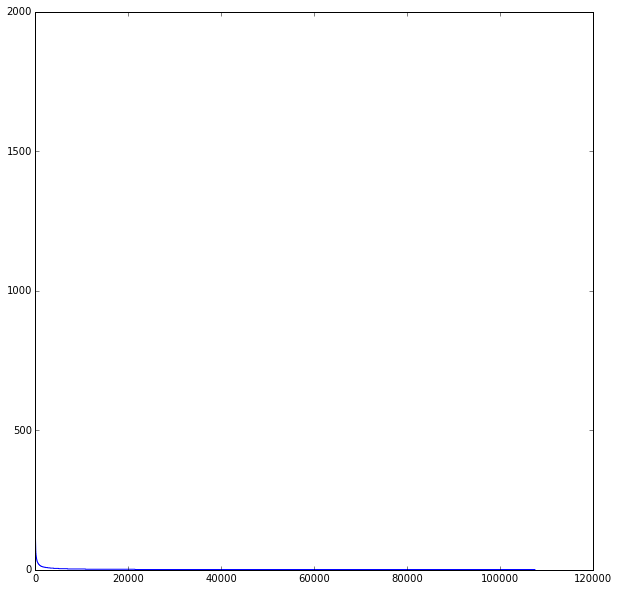

In [13]:
figure(figsize=(10, 10))
plot(count_grams[1])

### Using log-log plots
to better see the relation between the rank and the frequency, we use a log-log plot. THis is a plot in which both the X and the Y coordinate are scaled using $\log$. This allows us to look at changes aong many orders of magnitude.

$\log$ on x-axis & $\log$ on y-axis.

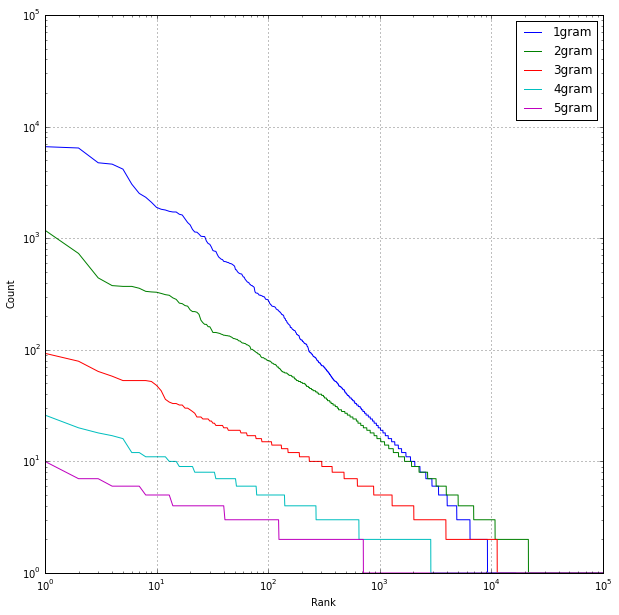

In [17]:
figure(figsize=(10, 10))
for i in xrange(5):
    loglog(count_grams[i],label=str(i+1)+'gram')
    
xlabel('Rank')
ylabel('Count')
xlim([1, 10**5])
legend()
grid()

###  Interpretation of the log-log graph - Power-Law distribution
Note that the graphs are approximately straight lines. 
because if we take the log of both sides we get a linear relation between the logs:
$$ \log (\mbox{count}) = -\alpha \log(\mbox{rank}) $$

This corresponds to dependencies of the form
$$ \mbox{count} = \frac{1}{\mbox{rank}^\alpha}$$


Note that for the Unigrams the slope is close to $\alpha=1$.  

Instead of looking at frequencies, we can divide by the total number of occurances and get a formula for the probability of the word at rank $r$: 
$$P(r) = \frac{C}{r^\alpha}$$ 
where $C$ is a normalization factor.

But this raises a difficulty, is it possible to define a distribution using this formula for $\alpha=1$?

This type of distribution is called a Power-Law distribution, or a [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law). Such distributions are **very common in natural language analysis** and in many other domains, from the distribution of the magnitude of earth-quakes, to the distribution in the size of towns and cities.

An Important aspect of power law is that a large number of small counts make a large fraction of the total. This causes problems in statistical analysis, as we will see below.

### Studying the statistical significance of bigrams

We are going to use the statistical relationship between words in a bigram to identify word pairs that are characteristic of Moby Dick.

The idea is that bigrams that appear many times are more significant than those that appear a few times.

For easier manipulation, we organize the unigrams and bigrams as DataFrames.

In [20]:
# compute total number of Bigrams and Unigrams to calculate probabilities
n_uni = freq_ngrams[1].map(lambda (n,v): n).reduce(add)+0.0
n_bi = freq_ngrams[2].map(lambda (n,v): n).reduce(add)+0.0
print 'number of unigrams=', n_uni,'number of bigrams=', n_bi

number of unigrams= 211152.0 number of bigrams= 203700.0


## SQL
**Why schema**. Schema as structured data in lieu of nested tuple. Turning unstructured data to structured data.

In [23]:
sqlContext = SQLContext(sc)
from pyspark.sql.types import Row, StructField, StructType, StringType, IntegerType, FloatType

In [22]:
schema = StructType([StructField("word", StringType(), False),
                     StructField("count", IntegerType(), False),
                     StructField("prob", FloatType(), False)])

unigram = sqlContext.createDataFrame(freq_ngrams[1].map(lambda (cnt,v): (v[0], cnt, float(cnt/n_uni))), schema)
unigram.take(5)

[Row(word=u'the', count=14440, prob=0.0683867558836937),
 Row(word=u'of', count=6608, prob=0.031294990330934525),
 Row(word=u'and', count=6432, prob=0.030461467802524567),
 Row(word=u'a', count=4741, prob=0.02245301939547062),
 Row(word=u'to', count=4609, prob=0.021827878430485725)]

In [25]:
schema = StructType([StructField("word1", StringType(), False),
                     StructField("word2", StringType(), False),
                     StructField("pair_count", IntegerType(), False),
                     StructField("pair_prob", FloatType(), False)])

bigram = sqlContext.createDataFrame(freq_ngrams[2].map(lambda (cnt, v): (v[0], v[1], cnt, float(cnt/n_bi))),schema)
bigram.take(5)

[Row(word1=u'of', word2=u'the', pair_count=1880, pair_prob=0.009229258634150028),
 Row(word1=u'in', word2=u'the', pair_count=1179, pair_prob=0.005787923466414213),
 Row(word1=u'to', word2=u'the', pair_count=730, pair_prob=0.0035837015602737665),
 Row(word1=u'from', word2=u'the', pair_count=441, pair_prob=0.0021649484988301992),
 Row(word1=u'the', word2=u'whale', pair_count=376, pair_prob=0.0018458517733961344)]

### The importance of a base model - simple ration, pre KL-divergence
Looking at the list above, we realize that the fact that a particular pair appears many times in the text is not
enough to make it significant. The top pairs in the list above: 'of the','in the', 'to the' are combinations of extremely common words. The high frequency of the pairs can be explained by the fact that the individual words are very common.

To better measure this importance we need some way to quantify how "surprising" or "unpredictable" the high frequency of the word is. A common way to do that is to compare the frequency of the appearance of the pair to the frequency we would expect if the words were drawn independently at random.

From the unigram counts we can estimate the probability of each word alone:
$$ P(word)=\frac{\mbox{no. of occurances of word}}{\mbox{total number of words}} $$

Similarly, for each word pair `(word1,word2)` we can estimate a probability 
$$ P((word1,word2))=\frac{\mbox{no. of occurances of (word1,word2)}}{\mbox{total number of word pairs}} $$

If the two words are drawn independently, we expect to see $P((word1,words)) \approx P(word1) P(word2)$
While if the word pair is significantly frequent, $P((word1,words)) \gg P(word1) P(word2)$.

A natural way to quantify the significance is to look at the ratio:
$$ \mbox{ratio} \triangleq \frac{P((word1,word2))}{P(word1) P(word2)} $$

(In fact, it is common to use the log of the ratio, which limits the extremes. Here I stick to ratio because the log caused some annoying problems which I have yet to fix).

We will use the DataFrame [join](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.join) to bring together the information we need on each bigram.

In [26]:
%%time
table = bigram.join(unigram, bigram.word1==unigram.word, 'inner')\
            .withColumnRenamed('prob', 'P1').withColumnRenamed('count', 'count1').drop('word')
table = table.join(unigram, bigram.word2==unigram.word, 'inner')\
            .withColumnRenamed('prob', 'P2').withColumnRenamed('count', 'count2').drop('word')
table = table.sort("pair_prob", ascending=False).cache()

CPU times: user 0 ns, sys: 80 ms, total: 80 ms
Wall time: 17.7 s


In [28]:
import math
def logCheck(x):
    try:
        return math.log(x)
    except:
        return -1.0
    
# .withColumn, adding/replacing a new column
table2 = table.withColumn('ratio', table.pair_prob/(table.P1*table.P2)).sort('ratio', ascending=False).cache()
table2.take(5)

[Row(word1=u'marl', word2=u'bequeathed', pair_count=1, pair_prob=4.909180006507086e-06, count1=1, P1=4.73592490379815e-06, count2=1, P2=4.73592490379815e-06, ratio=218876.61084986816),
 Row(word1=u'sufficit', word2=u'si', pair_count=1, pair_prob=4.909180006507086e-06, count1=1, P1=4.73592490379815e-06, count2=1, P2=4.73592490379815e-06, ratio=218876.61084986816),
 Row(word1=u'antemosaic', word2=u'unsourced', pair_count=1, pair_prob=4.909180006507086e-06, count1=1, P1=4.73592490379815e-06, count2=1, P2=4.73592490379815e-06, ratio=218876.61084986816),
 Row(word1=u'knotty', word2=u'aroostook', pair_count=1, pair_prob=4.909180006507086e-06, count1=1, P1=4.73592490379815e-06, count2=1, P2=4.73592490379815e-06, ratio=218876.61084986816),
 Row(word1=u'habeat', word2=u'caput', pair_count=1, pair_prob=4.909180006507086e-06, count1=1, P1=4.73592490379815e-06, count2=1, P2=4.73592490379815e-06, ratio=218876.61084986816)]

### No Filter of times of occurrences

Filter tf is a common heuristics for NLP and Info retrieval analysis. 

If we use no filter all of the pairs that have the top ratio are pairs that occur once and that is the only occurance of both words

In [29]:
# drop intermediate information 
table2.drop('pair_prob').drop('P1').drop('P2').take(10)

[Row(word1=u'marl', word2=u'bequeathed', pair_count=1, count1=1, count2=1, ratio=218876.61084986816),
 Row(word1=u'sufficit', word2=u'si', pair_count=1, count1=1, count2=1, ratio=218876.61084986816),
 Row(word1=u'antemosaic', word2=u'unsourced', pair_count=1, count1=1, count2=1, ratio=218876.61084986816),
 Row(word1=u'knotty', word2=u'aroostook', pair_count=1, count1=1, count2=1, ratio=218876.61084986816),
 Row(word1=u'habeat', word2=u'caput', pair_count=1, count1=1, count2=1, ratio=218876.61084986816),
 Row(word1=u'clootz', word2=u'deputation', pair_count=1, count1=1, count2=1, ratio=218876.61084986816),
 Row(word1=u'nailest', word2=u'geese', pair_count=1, count1=1, count2=1, ratio=218876.61084986816),
 Row(word1=u'journeyman', word2=u'joiner', pair_count=1, count1=1, count2=1, ratio=218876.61084986816),
 Row(word1=u'nondescript', word2=u'provincialisms', pair_count=1, count1=1, count2=1, ratio=218876.61084986816),
 Row(word1=u'objected', word2=u'reserving', pair_count=1, count1=1, co

### Keep pairs that appear more than 2 times
 Filtering words that appear 1 or 2 times still focused on very rare words. These word pairs can be treated as combined words, because they always appear together.

In [30]:
table3 = table2.filter(table2.pair_count > 2).sort('ratio', ascending=False).cache()

table3.drop('pair_prob').drop('P1').drop('P2').take(10)

[Row(word1=u'jesty', word2=u'joky', pair_count=3, count1=3, count2=3, ratio=72958.87567098437),
 Row(word1=u'joky', word2=u'hoky', pair_count=3, count1=3, count2=3, ratio=72958.87567098437),
 Row(word1=u'gamy', word2=u'jesty', pair_count=3, count1=3, count2=3, ratio=72958.87567098437),
 Row(word1=u'sporty', word2=u'gamy', pair_count=3, count1=3, count2=3, ratio=72958.87567098437),
 Row(word1=u'sperma', word2=u'ceti', pair_count=3, count1=3, count2=3, ratio=72958.87567098437),
 Row(word1=u'hoky', word2=u'poky', pair_count=3, count1=3, count2=3, ratio=72958.87567098437),
 Row(word1=u'vinegar', word2=u'cruet', pair_count=4, count1=4, count2=4, ratio=54719.15271246704),
 Row(word1=u'ross', word2=u'browne', pair_count=3, count1=3, count2=5, ratio=43775.32600449505),
 Row(word1=u'funny', word2=u'sporty', pair_count=3, count1=5, count2=3, ratio=43775.32600449505),
 Row(word1=u'deacon', word2=u'deuteronomy', pair_count=4, count1=5, count2=4, ratio=43775.32284711603)]

### Keep pairs with more than five occurances.
Now we start to see more interesting pairs, these consist of words that appear often without the other, but still, have a strong tendency to appear together.

In [31]:
table3=table2.filter(table2.pair_count > 5).sort('ratio', ascending=False).cache()

table3.drop('pair_prob').drop('P1').drop('P2').take(10)

[Row(word1=u'samuel', word2=u'enderby', pair_count=6, count1=11, count2=7, ratio=17055.32004741664),
 Row(word1=u'sag', word2=u'harbor', pair_count=7, count1=8, count2=13, ratio=14732.079859033098),
 Row(word1=u'father', word2=u'mapple', pair_count=9, count1=25, count2=9, ratio=8755.065031667347),
 Row(word1=u'lamp', word2=u'feeder', pair_count=6, count1=26, count2=6, ratio=8418.331763670947),
 Row(word1=u'seventy', word2=u'seventh', pair_count=6, count1=22, count2=9, ratio=6632.624936638165),
 Row(word1=u'pivot', word2=u'hole', pair_count=7, count1=7, count2=42, ratio=5211.3476365044025),
 Row(word1=u'jack', word2=u'knife', pair_count=8, count1=14, count2=30, ratio=4169.078390959528),
 Row(word1=u'steering', word2=u'oar', pair_count=6, count1=13, count2=25, ratio=4040.799133731693),
 Row(word1=u'o', word2=u'clock', pair_count=11, count1=44, count2=14, ratio=3908.5108880848975),
 Row(word1=u'dough', word2=u'boy', pair_count=15, count1=17, count2=58, ratio=3329.7660623700663)]

### More than 10 occurances
Now we see pairs that are characteristic to the book Moby Dick and are not overly rare. Note that many of the pairs relate to ships and Whaling.

According to Wikipedia

> **Dough Boy** is the pale, nervous steward of the ship.

In [41]:
table3=table2.filter(table2.pair_count > 10).sort('ratio', ascending=False).cache()

table3.drop('pair_prob').drop('P1').drop('P2').take(10)

[Row(word1=u'o', word2=u'clock', pair_count=11, count1=44, count2=14, ratio=3908.5108880848975),
 Row(word1=u'dough', word2=u'boy', pair_count=15, count1=17, count2=58, ratio=3329.7660623700663),
 Row(word1=u'cape', word2=u'horn', pair_count=13, count1=39, count2=27, ratio=2702.180688128714),
 Row(word1=u'town', word2=u'ho', pair_count=12, count1=32, count2=31, ratio=2647.7008807314105),
 Row(word1=u'moby', word2=u'dick', pair_count=67, count1=85, count2=67, ratio=2575.019169453124),
 Row(word1=u'try', word2=u'works', pair_count=14, count1=52, count2=25, ratio=2357.1327864204377),
 Row(word1=u'new', word2=u'bedford', pair_count=14, count1=99, count2=14, ratio=2210.874655617946),
 Row(word1=u'ha', word2=u'ha', pair_count=11, count1=36, count2=36, ratio=1857.7490421698274),
 Row(word1=u'she', word2=u'blows', pair_count=18, count1=119, count2=23, ratio=1439.4515457407115),
 Row(word1=u'chief', word2=u'mate', pair_count=16, count1=37, count2=72, ratio=1314.5743031513541)]

### More than 50 occurances
We see some more pairs that are related to moby dick such as **sperm whale** but we also start to see pairs that are generic english: `more than, had been` etc. (*problem with high frequency filter*).



In [43]:
table3=table2.filter(table2.pair_count > 50).sort('ratio', ascending=False).cache()

table3.drop('pair_prob').drop('P1').drop('P2').take(10)

[Row(word1=u'moby', word2=u'dick', pair_count=67, count1=85, count2=67, ratio=2575.019169453124),
 Row(word1=u'don', word2=u't', pair_count=118, count1=137, count2=284, ratio=663.8079905451489),
 Row(word1=u'sperm', word2=u'whale', pair_count=169, count1=243, count2=1132, ratio=134.4724567819884),
 Row(word1=u'at', word2=u'least', pair_count=52, count1=1317, count2=72, ratio=120.0285180598414),
 Row(word1=u'at', word2=u'last', pair_count=138, count1=1317, count2=262, ratio=87.53693588689998),
 Row(word1=u'i', word2=u'am', pair_count=73, count1=2098, count2=90, ratio=84.62024021811342),
 Row(word1=u'have', word2=u'been', pair_count=120, count1=766, count2=412, ratio=83.22516361899197),
 Row(word1=u'more', word2=u'than', pair_count=57, count1=492, count2=309, ratio=82.06361025530641),
 Row(word1=u'had', word2=u'been', pair_count=115, count1=775, count2=412, ratio=78.83122505432115),
 Row(word1=u'old', word2=u'man', pair_count=76, count1=448, count2=485, ratio=76.55846428917685)]